# Install and Import

In [1]:
!pip install torchsummary

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
# Load in our libraries
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
plt.style.use('seaborn')
sns.set(font_scale=2) 
from tqdm import tqdm

%matplotlib inline
import torch
import torchvision
from PIL import Image
import random
import pickle


from metrics import ArcMarginProduct
from utils_arcface import EarlyStopping

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import math
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, models, transforms
import torchvision.transforms as T
from torchsummary import summary

In [4]:
random_seed = 629

In [5]:
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

# Config

In [6]:
batch_size = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr = 1e-5
epochs = 1000

# Load data

In [7]:
# with open('/content/drive/MyDrive/wafer/dataset/X_train.pickle', 'rb') as f:
#     X_train = pickle.load(f)
# with open('/content/drive/MyDrive/wafer/dataset/y_train.pickle', 'rb') as f:
#     y_train = pickle.load(f)
# with open('/content/drive/MyDrive/wafer/dataset/X_valid.pickle', 'rb') as f:
#     X_valid = pickle.load(f)
# with open('/content/drive/MyDrive/wafer/dataset/y_valid.pickle', 'rb') as f:
#     y_valid = pickle.load(f)
# with open('/content/drive/MyDrive/wafer/dataset/X_test.pickle', 'rb') as f:
#     X_test = pickle.load(f)
# with open('/content/drive/MyDrive/wafer/dataset/y_test.pickle', 'rb') as f:
#     y_test = pickle.load(f)
with open('data/wm_38_X_train.pickle', 'rb') as f:
    X_train_38 = pickle.load(f)
with open('data/wm_38_y_train.pickle', 'rb') as f:
    y_train_38 = pickle.load(f)
with open('data/wm_38_X_valid.pickle', 'rb') as f:
    X_valid_38 = pickle.load(f)
with open('data/wm_38_y_valid.pickle', 'rb') as f:
    y_valid_38 = pickle.load(f)
with open('data/wm_38_X_test.pickle', 'rb') as f:
    X_test_38 = pickle.load(f)
with open('data/wm_38_y_test.pickle', 'rb') as f:
    y_test_38 = pickle.load(f)

In [8]:
np.unique(y_train_38, return_counts = True)     

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([600, 600, 600, 600, 600,  89, 600, 519, 600]))

In [9]:
# X_train = X_train.unsqueeze(1)
# X_valid = X_valid.unsqueeze(1)
# X_test = X_test.unsqueeze(1)
X_train_38 = X_train_38.unsqueeze(1)
X_valid_38 = X_valid_38.unsqueeze(1)
X_test_38 = X_test_38.unsqueeze(1)

In [10]:
# y_train = torch.Tensor(y_train).type(torch.int64)
# y_valid = torch.Tensor(y_valid).type(torch.int64)
# y_test = torch.Tensor(y_test).type(torch.int64)
y_train = torch.Tensor(y_train_38).type(torch.int64)
y_valid = torch.Tensor(y_valid_38).type(torch.int64)
y_test= torch.Tensor(y_test_38).type(torch.int64)

In [11]:
# X_train = torch.concat([X_train, X_train_38], axis = 0)
# X_valid = torch.concat([X_valid, X_valid_38], axis = 0)
# X_test = torch.concat([X_test,X_test_38], axis = 0)

# y_train = torch.concat([y_train, y_train_38], axis = 0)
# y_valid = torch.concat([y_valid, y_valid_38], axis = 0)
# y_test = torch.concat([y_test, y_test_38], axis = 0)

In [12]:
X_train = torch.where(X_train_38 == 2.0, 2.0, 0.0)
X_valid = torch.where(X_valid_38 == 2.0, 2.0, 0.0)
X_test = torch.where(X_test_38 == 2.0, 2.0, 0.0)

# X_train = torch.where(X_train == 2.0, 2.0, 0.0)
# X_valid = torch.where(X_valid == 2.0, 2.0, 0.0)
# X_test = torch.where(X_test == 2.0, 2.0, 0.0)

In [13]:
# def _to_one_hot(y, num_classes):
#     scatter_dim = len(y.size())
#     y_tensor = y.view(*y.size(), -1)
#     zeros = torch.zeros(*y.size(), num_classes, dtype=y.dtype)
#     return zeros.scatter(scatter_dim, y_tensor, 1)
# y_train = _to_one_hot(y_train_38, 9)
# y_valid = _to_one_hot(y_valid_38, 9)
# y_test = _to_one_hot(y_test_38, 9)

# y_train = _to_one_hot(y_train, 9)
# y_valid = _to_one_hot(y_valid, 9)
# y_test = _to_one_hot(y_test, 9)

In [14]:
preprocess = T.Compose([
   T.RandomHorizontalFlip(0.3),
   T.RandomVerticalFlip(0.3) 
])

In [15]:
class WaferSet(Dataset):
    def __init__(self, X, y, transform):
        self.X = X
        self.y = y
        self.transformer = transform

    def __getitem__(self, idx):
        X = self.X[idx]
        X = self.transformer(X)
        y = self.y[idx]
        return X, y

    def __len__(self):
        return len(self.X)

In [16]:
train_dataset = WaferSet(X_train, y_train, preprocess)
valid_dataset = torch.utils.data.TensorDataset(X_valid, y_valid)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

In [17]:
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = 4, pin_memory = True)
valid_loader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = False, num_workers = 4, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, num_workers = 4, pin_memory = True)

# Model

In [130]:
class base_line(nn.Module):
    def __init__(self):
        super(base_line, self).__init__()
        
        self.fc1 = nn.Linear(256, 128, bias=True) # fully connected, 
        self.fc2 = nn.Linear(128, 128, bias = True)
        self.fc3 = nn.Linear(128, 9, bias=True) #오류패턴 9개로 출력 9
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(0.1)
        
        self.layer1 =nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding = 1),#1번째 conv layer : 입력 층 3, 출력 32, Relu, Poolling으로 MAX 직용.
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding = 0))

    
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding = 1), #2번째 conv layer : 입력 층 32, 출력 64, Relu, Poolling으로 MAX 직용.
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding = 0))
        

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding = 1), #3번째 conv layer : 입력 층 64, 출력 128, Relu, Polling으로 Max 적용.
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding = 0))
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, stride=2, padding = 3), #3번째 conv layer : 입력 층 64, 출력 128, Relu, Polling으로 Max 적용.
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding = 0))
        self.layer5 = nn.Sequential(
            self.dropout,
            self.fc1,
            self.tanh,
            self.dropout,
            self.fc2,
            self.tanh
        )
        self.global_avg_pool = nn.AvgPool2d(kernel_size = 2,stride = 1, padding=0)
 

        
    # def printout(self, x):
    #     out = self.layer1(x)
    #     print(out)
    #     out = self.layer2(out)
    #     print(out)
    #     out = self.layer3(out)
    #     print(out)
    #     out = self.layer4(out)
    #     print(out)
    #     out = self.global_avg_pool(out)
    #     out = self.layer5(out)
    #     print(out)
    #     out = self.fc3(out)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.global_avg_pool(out)   # fully conntect를위해 flatten을 함.
        out = out.view(-1, 32)
        # out = self.layer5(out)
        return out    

base_line = base_line().to(device)

# Train

In [131]:
metric_fc = ArcMarginProduct(32, 9, s=32, m=0.5, easy_margin=False).to(device)
metric_fc

ArcMarginProduct()

In [132]:
criterion = torch.nn.CrossEntropyLoss().to(device) # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.AdamW([{'params': base_line.parameters()}, {'params': metric_fc.parameters()}], lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
# optimizer = torch.optim.AdamW(base_line.parameters(), lr=lr)

In [133]:
def train_epoch(model, dataloader,loss_fn,optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in dataloader:
        images = images.float().to(device)
        labels = labels.to(device)
        # labels = labels.float().reshape(images.size(0), 9).to(device)
        optimizer.zero_grad()
        embeded = model(images)
        output = metric_fc(embeded,labels)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        predictions = torch.argmax(output, 1)
        # labels = torch.argmax(labels, dim=1).float()
        train_correct += (predictions == labels).sum().item()
    return train_loss,train_correct
  
def valid_epoch(model,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for images, labels in dataloader:
        images = images.float().to(device)
        labels = labels.to(device)
        # labels = labels.float().reshape(images.size(0), 9).to(device)
        embeded = model(images)
        output = metric_fc(embeded, labels)
        loss=loss_fn(output,labels)
        valid_loss+=loss.item() * images.size(0)
        # labels = torch.argmax(labels, dim=1).float()
        predictions = torch.argmax(output, 1)
        val_correct+=(predictions == labels).sum().item()
    return valid_loss,val_correct

In [134]:
history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

early_stopping = EarlyStopping(patience = 20, verbose = True)
for epoch in range(epochs):
    train_loss, train_correct=train_epoch(base_line,train_loader,criterion,optimizer)
    test_loss, test_correct=valid_epoch(base_line,valid_loader,criterion)
    train_loss = train_loss / len(train_loader.sampler)
    train_acc = train_correct / len(train_loader.sampler) * 100
    test_loss = test_loss / len(valid_loader.sampler)
    test_acc = test_correct / len(valid_loader.sampler) * 100
    
    print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                            epochs,
                                                                                                            train_loss,
                                                                                                            test_loss,
                                                                                                            train_acc,
                                                                                                            test_acc))
    
    early_stopping(-test_acc, base_line, metric_fc) # 현재 과적합 상황 추적
    
    if early_stopping.early_stop: # 조건 만족 시 조기 종료
        break
    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    history['train_acc'].append(train_acc)
    history['test_acc'].append(test_acc)



Epoch:1/1000 AVG Training Loss:17.311 AVG Test Loss:15.883 AVG Training Acc 0.00 % AVG Test Acc 0.00 %
Validation loss decreased (0.000000 --> -0.000000).  Saving model ...
Epoch:2/1000 AVG Training Loss:15.272 AVG Test Loss:14.682 AVG Training Acc 0.00 % AVG Test Acc 0.00 %
Validation loss decreased (-0.000000 --> -0.000000).  Saving model ...
Epoch:3/1000 AVG Training Loss:14.158 AVG Test Loss:13.658 AVG Training Acc 1.19 % AVG Test Acc 6.49 %
Validation loss decreased (-0.000000 --> -6.494588).  Saving model ...
Epoch:4/1000 AVG Training Loss:13.249 AVG Test Loss:12.776 AVG Training Acc 8.32 % AVG Test Acc 9.74 %
Validation loss decreased (-6.494588 --> -9.741882).  Saving model ...
Epoch:5/1000 AVG Training Loss:12.168 AVG Test Loss:11.432 AVG Training Acc 10.25 % AVG Test Acc 11.91 %
Validation loss decreased (-9.741882 --> -11.906744).  Saving model ...
Epoch:6/1000 AVG Training Loss:10.983 AVG Test Loss:10.257 AVG Training Acc 15.02 % AVG Test Acc 18.65 %
Validation loss decreas

In [135]:
base_line.load_state_dict(torch.load('arcface_ckpt/model1checkpoint.pt'))
metric_fc.load_state_dict(torch.load('arcface_ckpt/model2checkpoint.pt'))

<All keys matched successfully>

# plotting

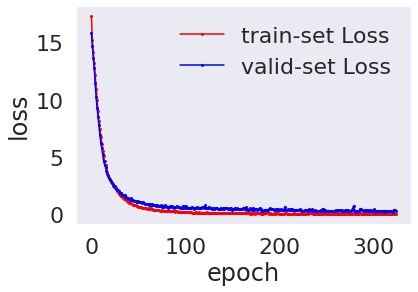

In [136]:
x_len = np.arange(len(history['train_loss']))
plt.plot(x_len, history['train_loss'], marker='.', c='red', label="train-set Loss")
plt.plot(x_len, history['test_loss'], marker='.', c='blue', label="valid-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# Confusion matrix

<AxesSubplot:>

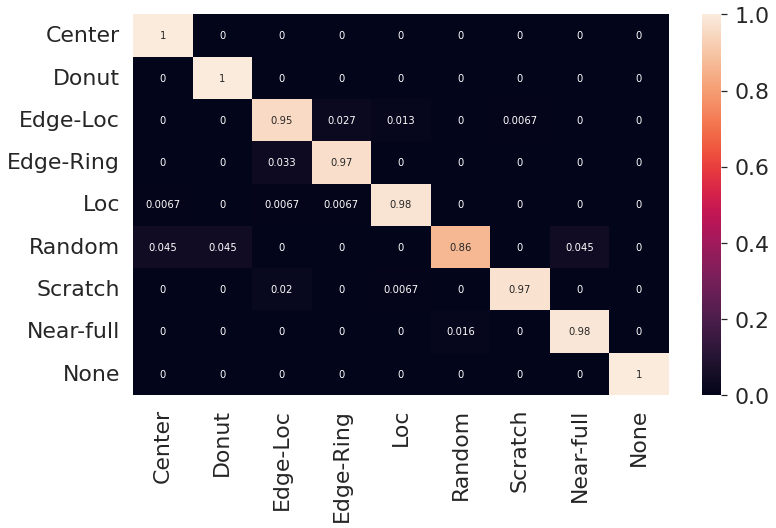

In [137]:
y_pred = []
y_true = []

# iterate over test data
with torch.no_grad():
    for images, labels in valid_loader:
        images = images.float().to(device)
        labels = labels.to(device)
        # labels = labels.float().reshape(images.size(0), 9).to(device)
        embeded = base_line(images)
        output = metric_fc(embeded,labels)
        pred = output.argmax(axis = 1).detach().cpu().numpy()
        y_pred.extend(pred) # Save Prediction
        # labels = labels.argmax(axis = 1).detach().cpu().numpy()
        y_true.extend(labels.detach().cpu().numpy()) # Save Truth

# constant for classes
classes = ('Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Random', 'Scratch','Near-full' ,'None')
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                    columns = [i for i in classes])
for i in range(len(df_cm)):
    n_sample = df_cm.iloc[i].sum()
    df_cm.iloc[i] = df_cm.iloc[i]/n_sample
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)



In [138]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=  ('Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Random', 'Scratch', 'Near-full', 'none')))
# mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}

              precision    recall  f1-score   support

      Center       0.99      1.00      0.99       150
       Donut       0.99      1.00      1.00       150
    Edge-Loc       0.94      0.95      0.95       150
   Edge-Ring       0.97      0.97      0.97       150
         Loc       0.98      0.98      0.98       150
      Random       0.90      0.86      0.88        22
     Scratch       0.99      0.97      0.98       150
   Near-full       0.99      0.98      0.99       129
        none       1.00      1.00      1.00       150

    accuracy                           0.98      1201
   macro avg       0.97      0.97      0.97      1201
weighted avg       0.98      0.98      0.98      1201



<AxesSubplot:>

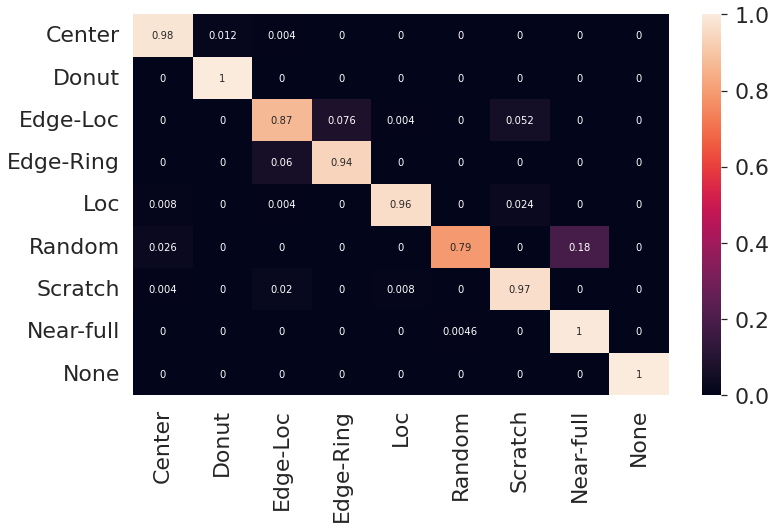

In [139]:
y_pred = []
y_true = []

# iterate over test data
with torch.no_grad():
    for images, labels in test_loader:
        images = images.float().to(device)
        labels = labels.to(device)
        # labels = labels.float().reshape(images.size(0), 9).to(device)
        embeded = base_line(images)
        output = metric_fc(embeded,labels)
        pred = output.argmax(axis = 1).detach().cpu().numpy()
        y_pred.extend(pred) # Save Prediction
        # labels = labels.argmax(axis = 1).detach().cpu().numpy()
        y_true.extend(labels.detach().cpu().numpy()) # Save Truth

# constant for classes
classes = ('Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Random', 'Scratch','Near-full' ,'None')
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                    columns = [i for i in classes])
for i in range(len(df_cm)):
    n_sample = df_cm.iloc[i].sum()
    df_cm.iloc[i] = df_cm.iloc[i]/n_sample
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)



In [140]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=  ('Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Random', 'Scratch','Near-full' ,'None')))

              precision    recall  f1-score   support

      Center       0.98      0.98      0.98       250
       Donut       0.99      1.00      0.99       250
    Edge-Loc       0.91      0.87      0.89       250
   Edge-Ring       0.93      0.94      0.93       250
         Loc       0.99      0.96      0.98       250
      Random       0.97      0.79      0.87        38
     Scratch       0.93      0.97      0.95       250
   Near-full       0.97      1.00      0.98       218
        None       1.00      1.00      1.00       250

    accuracy                           0.96      2006
   macro avg       0.96      0.95      0.95      2006
weighted avg       0.96      0.96      0.96      2006



In [141]:
class_embedding = metric_fc.weight

cos = nn.CosineSimilarity(dim=1, eps=1e-6)

similarity = []
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in valid_loader:
        images = images.float().to(device)
        labels = labels.to(device)
        # labels = labels.float().reshape(images.size(0), 9).to(device)
        embeded = base_line(images)
        output = metric_fc(embeded,labels)
        pred = output.argmax(axis = 1).detach().cpu().numpy()
        y_pred.extend(pred) # Save Prediction
        cos_sim = cos(embeded, class_embedding[labels])
        # labels = labels.argmax(axis = 1).detach().cpu().numpy()
        similarity.extend(cos_sim) # Save Prediction
        # labels = labels.argmax(axis = 1).detach().cpu().numpy()
        y_true.extend(labels.detach().cpu().numpy()) # Save Truth

y_pred = np.array(y_pred)
y_true = np.array(y_true)

In [142]:
wrong_idx = np.where(y_pred != y_true)[0]

low_sim = []
for item in wrong_idx:
    low_sim.append(similarity[item])

low_sim

[tensor(0.5177, device='cuda:0'),
 tensor(0.3425, device='cuda:0'),
 tensor(0.4816, device='cuda:0'),
 tensor(0.4246, device='cuda:0'),
 tensor(0.4251, device='cuda:0'),
 tensor(0.3315, device='cuda:0'),
 tensor(0.4065, device='cuda:0'),
 tensor(0.4830, device='cuda:0'),
 tensor(0.0862, device='cuda:0'),
 tensor(0.5029, device='cuda:0'),
 tensor(0.4394, device='cuda:0'),
 tensor(0.3780, device='cuda:0'),
 tensor(0.6485, device='cuda:0'),
 tensor(0.4691, device='cuda:0'),
 tensor(0.2825, device='cuda:0'),
 tensor(0.6068, device='cuda:0'),
 tensor(-0.0406, device='cuda:0'),
 tensor(0.5755, device='cuda:0'),
 tensor(0.4770, device='cuda:0'),
 tensor(0.5200, device='cuda:0'),
 tensor(0.5905, device='cuda:0'),
 tensor(0.5982, device='cuda:0'),
 tensor(0.6259, device='cuda:0'),
 tensor(0.5503, device='cuda:0')]

In [143]:
match_idx = np.where(y_pred == y_true)[0]

high_sim = []
for item in match_idx:
    high_sim.append(similarity[item].item())

high_sim = np.array(high_sim)

In [144]:
high_sim.mean()

0.7643607112443741